# ResNet Detector Developement 1

WNixalo - 1:4/5/2018

---

The purpose of this notebook is to experiment with small datasets (CPU dev) and finetune the general-purpose base object detector on the GLoC dataset.

## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *

sys.path.insert(1, os.path.join('../'))
from utils import common
from utils import temp_utils
from utils.subfolder_val_idxs import set_val_idxs

from matplotlib import patches, patheffects

In [3]:
PATH = Path('../data')
PATH_TRAIN     = PATH/'train'
PATH_TRAIN_BBX = PATH/'interstage_train'
PATH_CSV     = PATH/'labels.csv'
PATH_CSV_BBX = PATH/'interstage_labels.csv'
CPU_PATH_CSV     = PATH/'cpu_labels.csv'
CPU_PATH_CSV_BBX = PATH/'cpu_interstage_labels.csv'

## Data

### CPU data subset

***NOTE***: I'll have to rewrite my validation set indexer to work with CSVs instead of directories.

In [78]:
def remove_file(path):
    if os.path.exists(path): os.remove(path)
    return

remove_file(CPU_PATH_CSV)
remove_file(CPU_PATH_CSV_BBX)

In [80]:
sample = 1000
cpu_df = pd.read_csv(PATH_CSV).sample(n=sample)
cpu_idxs = [int(f_id.split('/')[-1]) for f_id in cpu_df['id'].values]
cpu_bbx_df = pd.read_csv(PATH_CSV_BBX).iloc[cpu_idxs]

cpu_df.to_csv(PATH/'cpu_labels.csv')
cpu_bbx_df.to_csv(PATH/'cpu_interstage_labels.csv')

### Visualizations

In [93]:
bbx = cpu_bbx_df.iloc[0].values[1:5]; bbx

array([148, 130, 246, 386], dtype=object)

In [236]:
def show_img(img, bbx, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, λw):
    o.set_path_effects([patheffects.Stroke(linewidth=λw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, bbx):
    # draw bounding box
    patch = ax.add_patch(patches.Rectangle(bbx[:2], *bbx[-2:], fill=False, edgecolor='white', lw=2)) # *bbx[:2] destructs bbx giving bbx[-2], bbx[-1]
    # outline it
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    # draw classification
    text = ax.text(*xy, 'Pilot', verticalalignment='top', color='white', fontsize=sz, weight='bold')
    # outline it
    draw_outline(text, 1)
    
def display_anno(img, bbx, clsfn=None):
    ax = show_img(img, bbx)
    draw_rect(ax, bbx)
    draw_text(ax, bbx[:2], clsfn)

#### Checking and fixing incorrect bounding boxes

003317-003603/003404.jpg


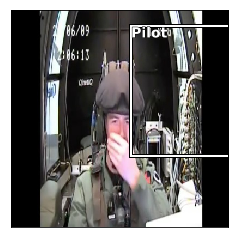

In [314]:
idx = np.random.randint(0, sample); #row = cpu_bbx_df.iloc[idx].values
bbx = cpu_bbx_df.iloc[idx].values[1:5]
f_img = cpu_df.iloc[idx].values[0] + '.jpg'
img = Image.open(PATH_TRAIN/f_img)
display_anno(img, bbx)
print(f_img)

In [315]:
bbx

array([221, 30, 298, 239], dtype=object)

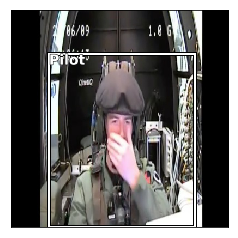

In [341]:
bbx[0] = 70; bbx[1] += 10; bbx[2] -= 0; bbx[3] += 0
display_anno(img, bbx)

In [345]:
cpu_bbx_df.iloc[idx].values[1:5]

array([221, 30, 298, 239], dtype=object)

In [353]:
cpu_bbx_df.iloc[idx]['x1']
cpu_bbx_df.iloc[idx].values[1:5]

array([221, 30, 298, 239], dtype=object)

In [357]:
df_bbx = pd.read_csv(PATH_CSV_BBX)

In [366]:
idx_id = int(cpu_bbx_df.iloc[idx]['id'].split('/')[-1].split('.jpg')[0]); idx_id

3404

In [368]:
df_bbx.iloc[idx_id]

id       interstage_train/003317-003603/003404.jpg
x1                                             221
y1                                              30
x2                                             298
y2                                             239
class                                        pilot
Name: 3404, dtype: object

In [371]:
cols = ['x1','y1','x2','y2']
for i,col in enumerate(cols):
    df_bbx.at[idx_id, col] = bbx[i]

In [372]:
df_bbx.iloc[idx_id]

id       interstage_train/003317-003603/003404.jpg
x1                                              70
y1                                              80
x2                                             268
y2                                             319
class                                        pilot
Name: 3404, dtype: object

Okay, that's corrected and just has to be saved to disk. But I'm not doing it *that* manually. I'll build a list of corrected bounding boxes and their image IDs, and run a loop to do it. I'm going to have to do this for the entire dataset - though I don't think there are *that* many incorrect labels. I'll have to switch to JSON format for my annotations later as well - to give me the flexibility to do multi-object detection (multiple instances of a pilot; pilot versus non-pulot; detect faces, eyes, etc.), although I'm not sure yet how to handle 'background' cases using what I have now.

Okay, maybe what I can do is change the class of every image without a bounding box to 'background' - and simply edit the loss function to throw those cases away, so that 'background' bounding box coordinates have no affect on the network.

Anyway, fixing the annotations will have to be done one way or another, so time to do that now in another notbeook.

In [376]:
set(df_bbx['class'].values)

{'pilot'}

In [377]:
df_bbx.to_csv(PATH_CSV_BBX, index=False)

... It turns out the reason why most of the bounding boxes that were looking wrong looked so was because I was display the coordinates wrong. The fastai pascal notebook was doing a conversion to xyhw, (or rchw?) wheras I have x1y1x2y2... That's embarrassing. I only lost about an hour on that journey.

In [24]:
def show_img(img, bbx, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(bbx):
    """returns (h w) from  (x1 y1 x2 y2) bounding box"""
    h = bbx[3]-bbx[1]
    w = bbx[2]-bbx[0]
    return h,w

def draw_outline(o, λw):
    o.set_path_effects([patheffects.Stroke(linewidth=λw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, bbx):
    # draw bounding box
    h,w = bb_hw(bbx)
    patch = ax.add_patch(patches.Rectangle(bbx[:2], w,h, fill=False, edgecolor='white', lw=2)) # *bbx[:2] destructs bbx giving bbx[-2], bbx[-1]
    # outline it
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    # draw classification
    text = ax.text(*xy, 'Pilot', verticalalignment='top', color='white', fontsize=sz, weight='bold')
    # outline it
    draw_outline(text, 1)
    
def display_anno(img, bbx, clsfn=None):
    ax = show_img(img, bbx)
    draw_rect(ax, bbx)
    draw_text(ax, bbx[:2], clsfn)

001190-001434/001405.jpg


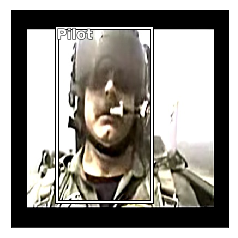

In [26]:
idx = np.random.randint(0, sample); #row = cpu_bbx_df.iloc[idx].values
bbx = cpu_bbx_df.iloc[idx].values[1:5]
f_img = cpu_df.iloc[idx].values[0] + '.jpg'
img = Image.open(PATH_TRAIN/f_img)
display_anno(img, bbx)
print(f_img)

Some of these are mislabeled, but not enough for me to care too much. I can fix that in v3. What's more concerning is what to do about the cases where the pilot isn't visible (background class). I'll find a way to treat them as background / dismiss them. I want to turn this from a 2-stage Detector-Classifier into a 1-stage End-to-End Detector.

#### Semi-Automating Annotation Correction

## Architecture

In [ ]:
class ConvBlock

In [ ]:
class SSD_Head(nn.Module):
    ## TODO